##seq2seq##

seq2seq은 encoder-decoder 구조로 이루어진 모델로 sequential data를 입력받고 출력하는 nlp의 여러 태스크에 사용될 수 있습니다.
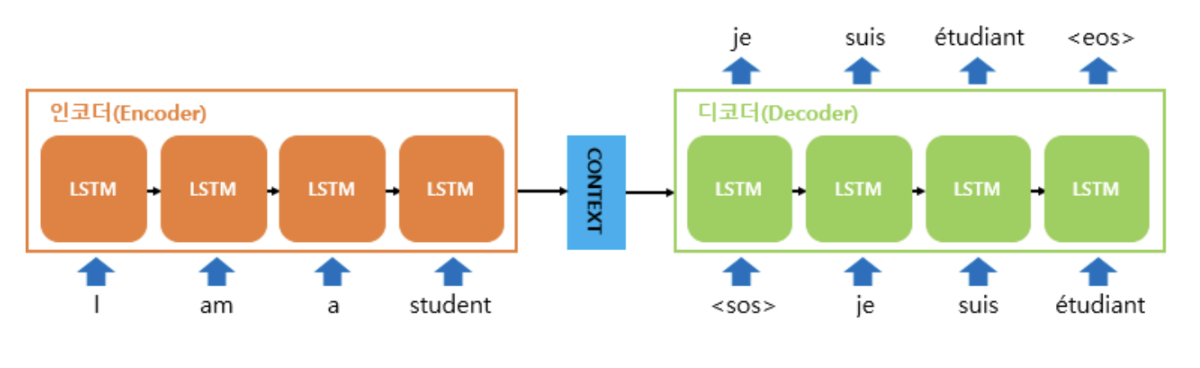

##Attention##

어텐션 기법은 Query, Key, Value를 기반으로 중요한 정보를 추출합니다.

어텐션은 현재 CV, NLP를 가리지 않고 여러 분야의 SOTA 모델에서 이용되는데,

dot product attention은 몇번의 행렬곱 연산으로 정의될 수 있어 연산 효율이 우수합니다.

seq2seq에 이용될 수 있는 attention을 행렬곱으로 정의해봅시다.

In [1]:
import torch
import torch.nn.functional as F

In [4]:
def Attention(Q, K, V):
  """
  Q : (hidden_size, 1) K : (hidden_size, num_key) V : (value_dim, num_key)
  """
  assert Q.shape[0] == K.shape[0], "Q, K vector size should match"
  assert K.shape[1] == V.shpae[1], "K, V should have same number"

  #  1. Q와 K의 유사도는 내적으로 나타내집니다. attention score 벡터를 만듭니다. (num_key, 1)
  #  att_score 행렬 사이즈가 num_key * 1이어야 하니까 K의 transpose에 Q를 행렬곱 적용해준다.
  att_score = torch.matmul(K.transpose(0,1), Q)

  #  2. 유사도 벡터에 softmax 연산을 가해 attention coefficient 벡터를 만듭니다. (num_key, 1)
  #  F.softmax()를 이용해서 att_score의 각 key에 대한 어텐션 가중치 계산
  att_coeff = F.softmax(att_score,dim=0)

  #  3. attention coefficient를 반영한 num_key개의 Value vector들의 평균을 찾습니다. (value_dim, 1)
  #  사실 결과 행렬 사이즈 보고 곱하긴 했지만...
  #  밸류랑 가중치랑 행렬곱 해주면 a1*v1 + a2*v2 + ... + an*vn 식으로 가중치 적용해주는것 같음
  att_val = torch.matmul(V, att_coeff)

  #  4. (value, )의 attentio_value로 만듭니다.
  #  (hint) Tensor.squeeze()
  att_val = att_val.squeeze()

  return att_val

attention은 수번의 행렬곱으로 정의되므로 병렬 연산에 능하다는 장점이 있습니다. 그러나 seq2seq에 적용된 attention은 seq2seq의 순전파를 기다려야 해 연산의 장점을 얻을 수 없습니다. 그 다음에 등장한 트랜스포머는 attention만을 사용한 모델입니다.

##Dataset & DataLoader##

pytorch에서 데이터 셋을 구축하고 파이프라인을 만드는 것은 대부분 torch.utils.data.Dataset 과 torch.utils.data.DataLoader로 이루어집니다.

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#loading-a-dataset

위 튜토리얼을 참고해 다음 질문에 답해주세요

#Q1#

Dataset 클래스를 상속받아서 나만의 데이터셋을 정의할 수 있습니다. 이때 dataset 클래스가 구현해야 하는 3가지 메서드는 무엇인가요?


In [5]:
"""
1. __init__     : 초기화 함수
2. __len__      : 데이터셋 샘플 개수 리턴
3. __getitem__  : 인덱스 값 받아서 데이터 셋 내부 해당 샘플 가져오기
"""

'\n1. __init__     : 초기화 함수\n2. __len__      : 데이터셋 샘플 개수 리턴\n3. __getitem__  : 인덱스 값 받아서 데이터 셋 내부 해당 샘플 가져오기\n'

Q2

DataLoader는 Dataset객체를 받아 일정한 batch 크기(batch_size) 단위로 접근할 수 있도록 iterator를 반환합니다. 데이터 셋을 일정한 크기의 배치로 쪼개어 사용하는 이용하는 이유는 무엇인가요?

In [6]:
"""
1. 큰 데이터셋을 활용할 때, 전체 데이터를 받아서 한번에 작업을 하려면 메모리에 부담이 크다.
2. GPU는 병렬 연산에 특화되어 있으므로, 배치를 쪼개서 여러개를 동시에 작업할 수 있다.
3. 미니 배치 그래디언트 디센트 같은 최적화 알고리즘을 사용할 때 하나의 샘플보단 일정한 사이즈의 배치를 사용하는게 더 좋은 결과를 낸다.
4. 모델 인풋을 정해진 사이즈로 넣어줘서 행렬 연산 수행을 편하게 해준다.
5. 여러개의 배치를 만들면 그만큼 훈련 과정에서 다양한 케이스를 마주할 수 있게 되어서 모델을 더욱 robust하게 길러준다.
"""

'\n1. 큰 데이터셋을 활용할 때, 전체 데이터를 받아서 한번에 작업을 하려면 메모리에 부담이 크다.\n2. GPU는 병렬 연산에 특화되어 있으므로, 배치를 쪼개서 여러개를 동시에 작업할 수 있다.\n3. 미니 배치 그래디언트 디센트 같은 최적화 알고리즘을 사용할 때 하나의 샘플보단 일정한 사이즈의 배치를 사용하는게 더 좋은 결과를 낸다.\n4. 모델 인풋을 정해진 사이즈로 넣어줘서 행렬 연산 수행을 편하게 해준다.\n5. 여러개의 배치를 만들면 그만큼 훈련 과정에서 다양한 케이스를 마주할 수 있게 되어서 모델을 더욱 robust하게 길러준다.\n'